## Import all the needed packages

In [1]:
%matplotlib inline

# DataFrame
import pandas as pd

# Elasticsearch
from elasticsearch import Elasticsearch, helpers

# datetime
from datetime import datetime

# isnan()
import math

# plot
import numpy as np
import matplotlib.pyplot as plt

## Create the local raw_data_pool

In [2]:
raw_data_pool = {}

def make_sure(src_site, dest_site):
    if src_site not in raw_data_pool:
        raw_data_pool[src_site] = {}
    if dest_site not in raw_data_pool[src_site]:
        raw_data_pool[src_site][dest_site] = pd.DataFrame()

def put_data(src_site, dest_site, timestamp_epoch, column_type, value):
    make_sure(src_site, dest_site)
    raw_data_pool[src_site][dest_site].set_value(timestamp_epoch, column_type, value)

## Create the elasticsearch connection

In [3]:
es = Elasticsearch(['atlas-kibana.mwt2.org:9200'])
my_index = "network_weather_2-*"
my_query = {}
my_timeout = 600

## Generate the query

In [170]:
# Note: this is just my weird way to do it when I first learned Elasticsearch, and you should not follow this way.
#       Please refer to Ilija's code to learn the normal and more efficient way to do it. 

src_site = "Australia-ATLAS"
dest_site = "SFU-LCG2"
timestamp = { 'gte': '2016-01-01', 'lt': '2016-06-01' }

my_query = {}
my_query['query'] = {}
my_query['query']['filtered'] = {}
my_query['query']['filtered']['query'] = { "match_all": {} }
my_query['query']['filtered']['filter'] = {}
my_query['query']['filtered']['filter']['bool'] = {}
my_query['query']['filtered']['filter']['bool']['must'] = []
my_query['query']['filtered']['filter']['bool']['must'].append({ 'term': { 'srcSite': src_site } })
my_query['query']['filtered']['filter']['bool']['must'].append({ 'term': { 'destSite': dest_site } })
my_query['query']['filtered']['filter']['bool']['must'].append({ 'range': { 'timestamp': timestamp } })
my_query['fielddata_fields'] = [ 'timestamp' ]

my_query

{'fielddata_fields': ['timestamp'],
 'query': {'filtered': {'filter': {'bool': {'must': [{'term': {'srcSite': 'Australia-ATLAS'}},
      {'term': {'destSite': 'SFU-LCG2'}},
      {'range': {'timestamp': {'gte': '2016-01-01', 'lt': '2016-06-01'}}}]}},
   'query': {'match_all': {}}}}}

## Get the data from Elasticsearch, and store the record based on its type

In [169]:
scroll = list(helpers.scan(client=es, query=my_query))
count = 0

for res in scroll:
    count += 1
    
    column_type = res['_type']
    timestamp_epoch = res['fields']['timestamp'][0]
    if column_type == 'latency':
        put_data(src_site, dest_site, timestamp_epoch, 'iso_8601', res['_source']['timestamp'])
        put_data(src_site, dest_site, timestamp_epoch, 'delay_median', res['_source']['delay_median'])
        put_data(src_site, dest_site, timestamp_epoch, 'delay_mean', res['_source']['delay_mean'])
        put_data(src_site, dest_site, timestamp_epoch, 'delay_sd', res['_source']['delay_sd'])
    elif column_type == 'packet_loss_rate':
        put_data(src_site, dest_site, timestamp_epoch, 'iso_8601', res['_source']['timestamp'])
        put_data(src_site, dest_site, timestamp_epoch, 'packet_loss', res['_source']['packet_loss'])
    elif column_type == 'throughput':
        put_data(src_site, dest_site, timestamp_epoch, 'iso_8601', res['_source']['timestamp'])
        put_data(src_site, dest_site, timestamp_epoch, 'throughput', res['_source']['throughput'])
    else:
        print("Error: type should be latency, packet_loss_rate, or throughput. ")

print(count)

114721


In [21]:
a = raw_data_pool[src_site][dest_site]

In [22]:
a.count(axis='index')    # Count how many records we get (after de-duplication)

iso_8601        3219
packet_loss     3177
delay_median    3105
delay_mean      3105
delay_sd        3105
throughput        21
dtype: int64

In [24]:
a

,iso_8601,packet_loss,delay_median,delay_mean,delay_sd,throughput
1451612100000,2016-01-01T01:35:00,0.0,84.4,84.447333,0.053786,NaN
1451614200000,2016-01-01T02:10:00,NaN,85.6,85.584200,0.092288,NaN
1451614500000,2016-01-01T02:15:00,0.0,NaN,NaN,NaN,NaN
1451616900000,2016-01-01T02:55:00,0.0,86.7,86.706333,0.050595,NaN
1452388500000,2016-01-10T01:15:00,0.0,81.3,81.277556,0.064778,NaN
1452390600000,2016-01-10T01:50:00,0.0,80.3,80.300167,0.043011,NaN
1452392400000,2016-01-10T02:20:00,0.0,83.0,83.004208,0.153796,NaN
1452394500000,2016-01-10T02:55:00,0.0,84.1,84.077417,0.147530,NaN
1452396600000,2016-01-10T03:30:00,0.0,83.7,83.706333,0.232149,NaN
1452547500000,2016-01-11T21:25:00,0.0,81.8,81.764667,0.052772,NaN


In [25]:
a.sort_index(inplace=True)    # Sort the records based on time

In [107]:
a

,iso_8601,packet_loss,delay_median,delay_mean,delay_sd,throughput
1451607300000,2016-01-01T00:15:00,0.000000,83.6,83.630125,0.049126,NaN
1451609700000,2016-01-01T00:55:00,0.000000,81.8,81.814667,0.052455,NaN
1451612100000,2016-01-01T01:35:00,0.000000,84.4,84.447333,0.053786,NaN
1451614200000,2016-01-01T02:10:00,NaN,85.6,85.584200,0.092288,NaN
1451614500000,2016-01-01T02:15:00,0.000000,NaN,NaN,NaN,NaN
1451616900000,2016-01-01T02:55:00,0.000000,86.7,86.706333,0.050595,NaN
1451619300000,2016-01-01T03:35:00,0.000000,85.0,85.004500,0.041590,NaN
1451621400000,2016-01-01T04:10:00,0.000000,83.8,83.813500,0.179447,NaN
1451623500000,2016-01-01T04:45:00,0.000000,82.6,82.614083,0.068629,NaN
1451625600000,2016-01-01T05:20:00,0.000000,82.5,84.487467,7.805751,NaN


In [26]:
a.to_pickle("raw_data_1.pkl")    # Store the data frame to pickle file on disk

In [28]:
t = a[a.throughput.notnull()]    # Get the lines (i.e. times) whose throughput is not null

In [29]:
t

,iso_8601,packet_loss,delay_median,delay_mean,delay_sd,throughput
1451675090000,2016-01-01T19:04:50,NaN,NaN,NaN,NaN,105920000.0
1451805042000,2016-01-03T07:10:42,NaN,NaN,NaN,NaN,606593000.0
1452076266000,2016-01-06T10:31:06,NaN,NaN,NaN,NaN,625393000.0
1452158122000,2016-01-07T09:15:22,NaN,NaN,NaN,NaN,460065000.0
1452661247000,2016-01-13T05:00:47,NaN,NaN,NaN,NaN,527882000.0
1452753236000,2016-01-14T06:33:56,NaN,NaN,NaN,NaN,308804000.0
1452794779000,2016-01-14T18:06:19,NaN,NaN,NaN,NaN,239490000.0
1453975840000,2016-01-28T10:10:40,NaN,NaN,NaN,NaN,552811000.0
1454047943000,2016-01-29T06:12:23,NaN,NaN,NaN,NaN,167993000.0
1454706290000,2016-02-05T21:04:50,NaN,NaN,NaN,NaN,681488000.0


In [30]:
t.shape

(21, 6)

In [33]:
# For the times when we have throughput data, extract the nearest three records around it
# (i.e. the record before it, the record itself, and the record after it)
dataframe_size = a.shape
dataframe_size
p = pd.DataFrame()
for r in range(dataframe_size[0]):
    if not math.isnan(a.iloc[r]['throughput']):
        if (r != 0) and (r != dataframe_size[0] - 1):
            p = p.append(a.iloc[r-1])
            p = p.append(a.iloc[r])
            p = p.append(a.iloc[r+1])

In [34]:
p

,delay_mean,delay_median,delay_sd,iso_8601,packet_loss,throughput
1451674500000,84.436417,84.4,1.625300,2016-01-01T18:55:00,0.0,NaN
1451675090000,NaN,NaN,NaN,2016-01-01T19:04:50,NaN,105920000.0
1451676600000,83.418900,83.4,0.112425,2016-01-01T19:30:00,0.0,NaN
1451803200000,76.117833,76.1,0.087742,2016-01-03T06:40:00,0.0,NaN
1451805042000,NaN,NaN,NaN,2016-01-03T07:10:42,NaN,606593000.0
1451805600000,83.026250,83.0,0.049016,2016-01-03T07:20:00,0.0,NaN
1452072900000,83.264583,83.0,1.278601,2016-01-06T09:35:00,0.0,NaN
1452076266000,NaN,NaN,NaN,2016-01-06T10:31:06,NaN,625393000.0
1452076800000,83.504767,83.8,0.435217,2016-01-06T10:40:00,0.0,NaN
1452157200000,82.699056,82.4,1.656276,2016-01-07T09:00:00,0.0,NaN


In [35]:
p.shape

(63, 6)

In [36]:
g = pd.DataFrame()

row = p.shape[0]
for r in range(row):
    line = p.iloc[r]
    if not math.isnan(line['throughput']):
        # This time has the throughput data
        g.set_value(p.index[r], 'iso_8601', line['iso_8601'])
        g.set_value(p.index[r], 'throughput', line['throughput'])
        
        if not math.isnan(line['delay_median']):
            # This time itself has the needed delay_median data
            g.set_value(p.index[r], 'delay_median', line['delay_median'])
        else:
            if (not math.isnan(p.iloc[r-1]['delay_median'])) and (not math.isnan(p.iloc[r+1]['delay_median'])):
                # Calculate the value based on the nearest two values
                g.set_value(p.index[r], 'delay_median', ( p.iloc[r-1]['delay_median'] + p.iloc[r+1]['delay_median'] ) / 2)
                # dmdtbm = delay_median_deltaT_before(minutes)
                # dmdtam = delay_median_deltaT_after(minutes)
                g.set_value(p.index[r], 'dmdtbm', (p.index[r] - p.index[r-1]) / 1000 / 60) # minutes
                g.set_value(p.index[r], 'dmdtam', (p.index[r+1] - p.index[r]) / 1000 / 60) # minutes
            else:
                print("Need work 1")
            
        if not math.isnan(line['packet_loss']):
            # This time itself has the needed packet_loss data
            g.set_value(p.index[r], 'packet_loss', line['packet_loss'])
        else:
            if (not math.isnan(p.iloc[r-1]['packet_loss'])) and (not math.isnan(p.iloc[r+1]['packet_loss'])):
                # Calculate the value based on the nearest two values
                g.set_value(p.index[r], 'packet_loss', ( p.iloc[r-1]['packet_loss'] + p.iloc[r+1]['packet_loss'] ) / 2)
                # pldtbm = packet_loss_deltaT_before(minutes)
                # pldtam = packet_loss_deltaT_after(minutes)
                g.set_value(p.index[r], 'pldtbm', (p.index[r] - p.index[r-1]) / 1000 / 60) # minutes
                g.set_value(p.index[r], 'pldtam', (p.index[r+1] - p.index[r]) / 1000 / 60) # minutes
            else:
                print("Need work 2")

g

,iso_8601,throughput,delay_median,dmdtbm,dmdtam,packet_loss,pldtbm,pldtam
1451675090000,2016-01-01T19:04:50,105920000.0,83.90,9.833333,25.166667,0.0,9.833333,25.166667
1451805042000,2016-01-03T07:10:42,606593000.0,79.55,30.700000,9.300000,0.0,30.700000,9.300000
1452076266000,2016-01-06T10:31:06,625393000.0,83.40,56.100000,8.900000,0.0,56.100000,8.900000
1452158122000,2016-01-07T09:15:22,460065000.0,82.65,15.366667,19.633333,0.0,15.366667,19.633333
1452661247000,2016-01-13T05:00:47,527882000.0,82.20,60.783333,9.216667,0.0,60.783333,9.216667
1452753236000,2016-01-14T06:33:56,308804000.0,82.70,18.933333,11.066667,0.0,18.933333,11.066667
1452794779000,2016-01-14T18:06:19,239490000.0,83.20,6.316667,28.683333,0.0,6.316667,28.683333
1453975840000,2016-01-28T10:10:40,552811000.0,81.45,0.666667,39.333333,0.0,0.666667,39.333333
1454047943000,2016-01-29T06:12:23,167993000.0,83.20,7.383333,27.616667,0.0,7.383333,27.616667
1454706290000,2016-02-05T21:04:50,681488000.0,88.65,49.833333,30.166667,0.0,49.833333,30.166667


In [38]:
g.to_pickle('before_drawing_1.pkl')

In [158]:
g = pd.read_pickle('before_drawing_1.pkl')

dm = g.delay_median
tp = g.throughput / 1024 / 1024 / 1024 / 8    # Should not divide by 8, so that we show value in Gbps rather than GB/s
pl = g.packet_loss


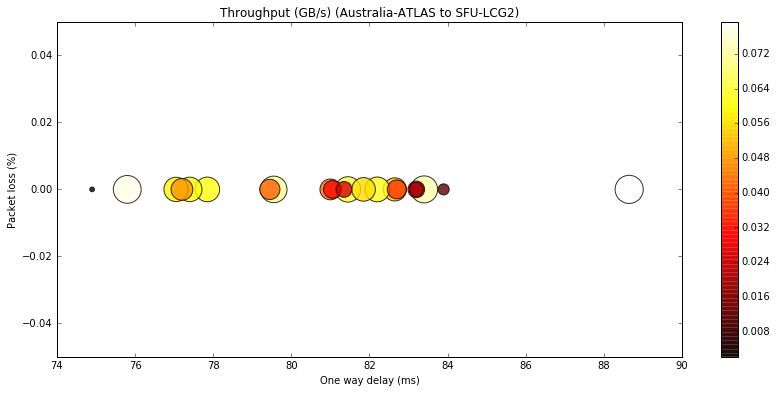

In [159]:
plt.figure(figsize=[14, 6])
plt.scatter(dm, pl, s=tp * 10000, c=tp, alpha=.8, cmap='hot')
plt.colorbar()
plt.xlabel('One way delay (ms)'), plt.ylabel('Packet loss (%)')
plt.title('Throughput (GB/s) (Australia-ATLAS to SFU-LCG2)')
plt.show()

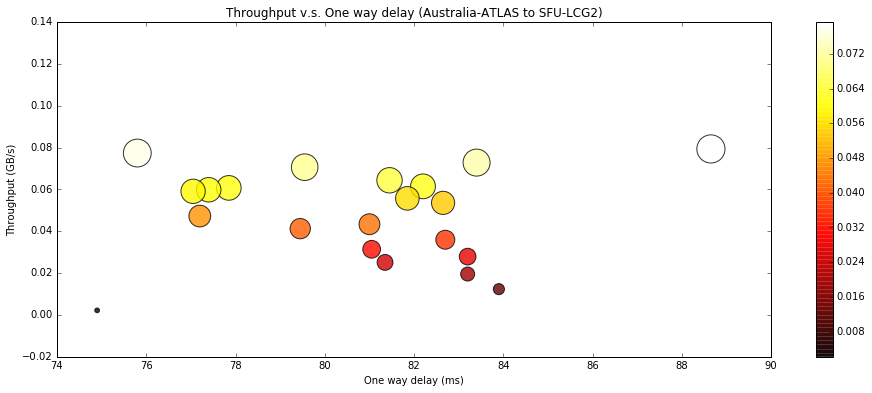

In [160]:
plt.figure(figsize=[16, 6])
plt.scatter(dm, tp, s=tp * 10000, c=tp, alpha=.8, cmap='hot')
plt.colorbar()
plt.xlabel('One way delay (ms)'), plt.ylabel('Throughput (GB/s)')
plt.title('Throughput v.s. One way delay (Australia-ATLAS to SFU-LCG2)')
plt.show()

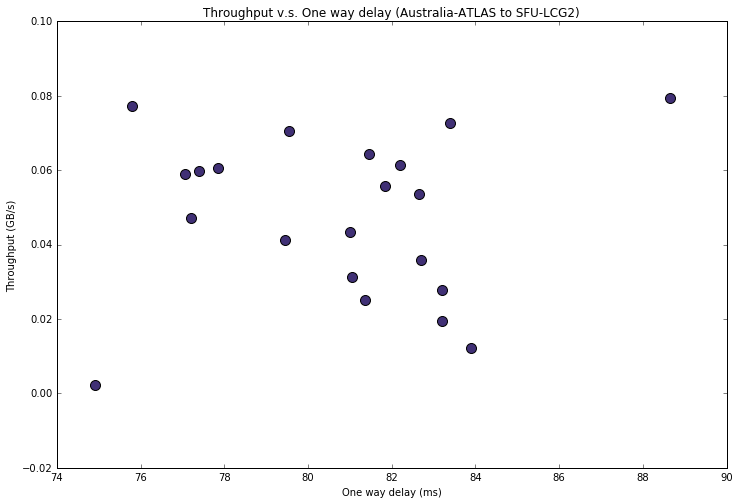

In [161]:
plt.figure(figsize=[12, 8])
plt.scatter(dm, tp, s=100, c='#403075')
plt.xlabel('One way delay (ms)'), plt.ylabel('Throughput (GB/s)')
plt.title('Throughput v.s. One way delay (Australia-ATLAS to SFU-LCG2)')
plt.show()

In [108]:
a

,iso_8601,packet_loss,delay_median,delay_mean,delay_sd,throughput
1451607300000,2016-01-01T00:15:00,0.000000,83.6,83.630125,0.049126,NaN
1451609700000,2016-01-01T00:55:00,0.000000,81.8,81.814667,0.052455,NaN
1451612100000,2016-01-01T01:35:00,0.000000,84.4,84.447333,0.053786,NaN
1451614200000,2016-01-01T02:10:00,NaN,85.6,85.584200,0.092288,NaN
1451614500000,2016-01-01T02:15:00,0.000000,NaN,NaN,NaN,NaN
1451616900000,2016-01-01T02:55:00,0.000000,86.7,86.706333,0.050595,NaN
1451619300000,2016-01-01T03:35:00,0.000000,85.0,85.004500,0.041590,NaN
1451621400000,2016-01-01T04:10:00,0.000000,83.8,83.813500,0.179447,NaN
1451623500000,2016-01-01T04:45:00,0.000000,82.6,82.614083,0.068629,NaN
1451625600000,2016-01-01T05:20:00,0.000000,82.5,84.487467,7.805751,NaN


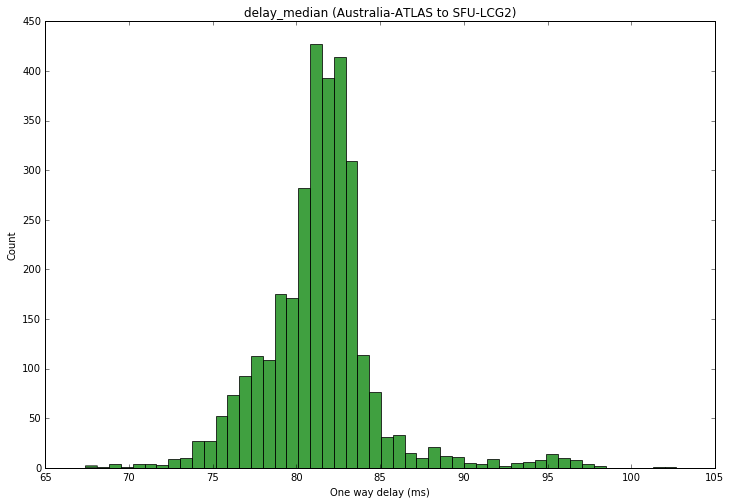

In [165]:
a = pd.read_pickle('raw_data_1.pkl')

d = a.delay_median
d = d[d.notnull()]

plt.figure(figsize=[12, 8])
plt.hist(d, 50, facecolor='green', alpha=0.75)
plt.xlabel('One way delay (ms)'), plt.ylabel('Count')
plt.title('delay_median (Australia-ATLAS to SFU-LCG2)')

In [135]:
src_site = "SFU-LCG2"
dest_site = "Australia-ATLAS"
timestamp = { 'gte': '2016-01-01T00:00:00Z', 'lt': '2016-06-01T00:00:00Z' }

my_query = {}
my_query['query'] = {}
my_query['query']['filtered'] = {}
my_query['query']['filtered']['query'] = { "match_all": {} }
my_query['query']['filtered']['filter'] = {}
my_query['query']['filtered']['filter']['bool'] = {}
my_query['query']['filtered']['filter']['bool']['must'] = []
my_query['query']['filtered']['filter']['bool']['must'].append({ 'term': { 'srcSite': src_site } })
my_query['query']['filtered']['filter']['bool']['must'].append({ 'term': { 'destSite': dest_site } })
my_query['query']['filtered']['filter']['bool']['must'].append({ 'range': { 'timestamp': timestamp } })
my_query['fielddata_fields'] = [ 'timestamp' ]

my_query

{'fielddata_fields': ['timestamp'],
 'query': {'filtered': {'filter': {'bool': {'must': [{'term': {'srcSite': 'SFU-LCG2'}},
      {'term': {'destSite': 'Australia-ATLAS'}},
      {'range': {'timestamp': {'gte': '2016-01-01T00:00:00Z',
         'lt': '2016-06-01T00:00:00Z'}}}]}},
   'query': {'match_all': {}}}}}

In [136]:
scroll = list(helpers.scan(client=es, query=my_query))
count = 0

for res in scroll:
    count += 1
    
    column_type = res['_type']
    timestamp_epoch = res['fields']['timestamp'][0]
    if column_type == 'latency':
        put_data(src_site, dest_site, timestamp_epoch, 'iso_8601', res['_source']['timestamp'])
        put_data(src_site, dest_site, timestamp_epoch, 'delay_median', res['_source']['delay_median'])
        put_data(src_site, dest_site, timestamp_epoch, 'delay_mean', res['_source']['delay_mean'])
        put_data(src_site, dest_site, timestamp_epoch, 'delay_sd', res['_source']['delay_sd'])
    elif column_type == 'packet_loss_rate':
        put_data(src_site, dest_site, timestamp_epoch, 'iso_8601', res['_source']['timestamp'])
        put_data(src_site, dest_site, timestamp_epoch, 'packet_loss', res['_source']['packet_loss'])
    elif column_type == 'throughput':
        put_data(src_site, dest_site, timestamp_epoch, 'iso_8601', res['_source']['timestamp'])
        put_data(src_site, dest_site, timestamp_epoch, 'throughput', res['_source']['throughput'])
    else:
        print("Error: type should be latency, packet_loss_rate, or throughput. ")

print(count)

84256


In [137]:
a = raw_data_pool[src_site][dest_site]

In [139]:
a.count(axis='index')

iso_8601        6056
packet_loss     5994
delay_median    5851
delay_mean      5851
delay_sd        5851
throughput        46
dtype: int64

In [140]:
a.sort_index(inplace=True)

In [141]:
a

,iso_8601,packet_loss,delay_median,delay_mean,delay_sd,throughput
1451606400000,2016-01-01T00:00:00,0.000000,92.00,92.031917,0.057790,NaN
1451607900000,2016-01-01T00:25:00,0.000556,93.90,93.893608,0.175130,NaN
1451609400000,2016-01-01T00:50:00,0.000000,93.50,93.536083,0.063361,NaN
1451610900000,2016-01-01T01:15:00,0.000000,92.30,92.257500,0.150921,NaN
1451612400000,2016-01-01T01:40:00,0.000000,90.80,90.821667,0.050963,NaN
1451613900000,2016-01-01T02:05:00,0.000000,91.00,91.053167,0.067007,NaN
1451615400000,2016-01-01T02:30:00,0.000000,89.60,89.596833,0.066383,NaN
1451616900000,2016-01-01T02:55:00,0.000000,88.90,88.812667,0.170976,NaN
1451618700000,2016-01-01T03:25:00,0.000000,90.80,90.711083,0.178752,NaN
1451621400000,2016-01-01T04:10:00,0.000000,91.80,91.809667,0.050727,NaN


In [142]:
a.to_pickle("raw_data_2.pkl")

In [143]:
t = a[a.throughput.notnull()]

In [144]:
t

,iso_8601,packet_loss,delay_median,delay_mean,delay_sd,throughput
1451808014000,2016-01-03T08:00:14,NaN,NaN,NaN,NaN,476976000.0
1451831764000,2016-01-03T14:36:04,NaN,NaN,NaN,NaN,58491900.0
1452128865000,2016-01-07T01:07:45,NaN,NaN,NaN,NaN,167364000.0
1453903607000,2016-01-27T14:06:47,NaN,NaN,NaN,NaN,56007400.0
1454012207000,2016-01-28T20:16:47,NaN,NaN,NaN,NaN,86426000.0
1454066962000,2016-01-29T11:29:22,NaN,NaN,NaN,NaN,54234400.0
1454465619000,2016-02-03T02:13:39,NaN,NaN,NaN,NaN,142425000.0
1454794730000,2016-02-06T21:38:50,NaN,NaN,NaN,NaN,288296000.0
1455135392000,2016-02-10T20:16:32,NaN,NaN,NaN,NaN,40935800.0
1455480599000,2016-02-14T20:09:59,NaN,NaN,NaN,NaN,184655000.0


In [145]:
t.shape

(46, 6)

In [146]:
dataframe_size = a.shape
dataframe_size
p = pd.DataFrame()
for r in range(dataframe_size[0]):
    if not math.isnan(a.iloc[r]['throughput']):
        if (r != 0) and (r != dataframe_size[0] - 1):
            p = p.append(a.iloc[r-1])
            p = p.append(a.iloc[r])
            p = p.append(a.iloc[r+1])

p

,delay_mean,delay_median,delay_sd,iso_8601,packet_loss,throughput
1451807100000,92.530667,92.5,0.055011,2016-01-03T07:45:00,0.000000,NaN
1451808014000,NaN,NaN,NaN,2016-01-03T08:00:14,NaN,476976000.0
1451808600000,92.296833,92.2,0.153029,2016-01-03T08:10:00,0.000000,NaN
1451831700000,89.500833,89.5,0.085338,2016-01-03T14:35:00,0.000000,NaN
1451831764000,NaN,NaN,NaN,2016-01-03T14:36:04,NaN,58491900.0
1451833200000,85.945917,85.4,1.805219,2016-01-03T15:00:00,0.000000,NaN
1452128100000,92.013000,92.0,0.066566,2016-01-07T00:55:00,0.000000,NaN
1452128865000,NaN,NaN,NaN,2016-01-07T01:07:45,NaN,167364000.0
1452129300000,92.870000,92.9,0.187972,2016-01-07T01:15:00,0.000000,NaN
1453828800000,90.863667,90.6,0.591535,2016-01-26T17:20:00,0.000000,NaN


In [147]:
g = pd.DataFrame()

row = p.shape[0]
for r in range(row):
    line = p.iloc[r]
    if not math.isnan(line['throughput']):
        # This time has the throughput data
        g.set_value(p.index[r], 'iso_8601', line['iso_8601'])
        g.set_value(p.index[r], 'throughput', line['throughput'])
        
        if not math.isnan(line['delay_median']):
            # This time itself has the needed delay_median data
            g.set_value(p.index[r], 'delay_median', line['delay_median'])
        else:
            if (not math.isnan(p.iloc[r-1]['delay_median'])) and (not math.isnan(p.iloc[r+1]['delay_median'])):
                g.set_value(p.index[r], 'delay_median', ( p.iloc[r-1]['delay_median'] + p.iloc[r+1]['delay_median'] ) / 2)
                # dmdtbm = delay_median_deltaT_before(minutes)
                # dmdtam = delay_median_deltaT_after(minutes)
                g.set_value(p.index[r], 'dmdtbm', (p.index[r] - p.index[r-1]) / 1000 / 60) # minutes
                g.set_value(p.index[r], 'dmdtam', (p.index[r+1] - p.index[r]) / 1000 / 60) # minutes
            else:
                print("Need work 1")
            
        if not math.isnan(line['packet_loss']):
            # This time itself has the needed packet_loss data
            g.set_value(p.index[r], 'packet_loss', line['packet_loss'])
        else:
            if (not math.isnan(p.iloc[r-1]['packet_loss'])) and (not math.isnan(p.iloc[r+1]['packet_loss'])):
                g.set_value(p.index[r], 'packet_loss', ( p.iloc[r-1]['packet_loss'] + p.iloc[r+1]['packet_loss'] ) / 2)
                # pldtbm = packet_loss_deltaT_before(minutes)
                # pldtam = packet_loss_deltaT_after(minutes)
                g.set_value(p.index[r], 'pldtbm', (p.index[r] - p.index[r-1]) / 1000 / 60) # minutes
                g.set_value(p.index[r], 'pldtam', (p.index[r+1] - p.index[r]) / 1000 / 60) # minutes
            else:
                print("Need work 2")

g

Need work 1
Need work 1


,iso_8601,throughput,delay_median,dmdtbm,dmdtam,packet_loss,pldtbm,pldtam
1451808014000,2016-01-03T08:00:14,476976000.0,92.35,15.233333,9.766667,0.000000,15.233333,9.766667
1451831764000,2016-01-03T14:36:04,58491900.0,87.45,1.066667,23.933333,0.000000,1.066667,23.933333
1452128865000,2016-01-07T01:07:45,167364000.0,92.45,12.750000,7.250000,0.000000,12.750000,7.250000
1453903607000,2016-01-27T14:06:47,56007400.0,91.30,1246.783333,93.216667,0.000000,1246.783333,93.216667
1454012207000,2016-01-28T20:16:47,86426000.0,92.55,36.783333,8.216667,0.000208,36.783333,8.216667
1454066962000,2016-01-29T11:29:22,54234400.0,91.75,4.366667,20.633333,0.000417,4.366667,20.633333
1454465619000,2016-02-03T02:13:39,142425000.0,93.85,3.650000,26.350000,0.000000,3.650000,26.350000
1454794730000,2016-02-06T21:38:50,288296000.0,93.55,8.833333,16.166667,0.000000,8.833333,16.166667
1455135392000,2016-02-10T20:16:32,40935800.0,82.00,11.533333,18.466667,0.000000,11.533333,18.466667
1455480599000,2016-02-14T20:09:59,184655000.0,80.10,4.983333,20.016667,0.000000,4.983333,20.016667


In [148]:
print(g.shape)
g = g[g.delay_median.notnull()]
print(g.shape)

(46, 8)
(44, 8)


In [149]:
g

,iso_8601,throughput,delay_median,dmdtbm,dmdtam,packet_loss,pldtbm,pldtam
1451808014000,2016-01-03T08:00:14,476976000.0,92.35,15.233333,9.766667,0.000000,15.233333,9.766667
1451831764000,2016-01-03T14:36:04,58491900.0,87.45,1.066667,23.933333,0.000000,1.066667,23.933333
1452128865000,2016-01-07T01:07:45,167364000.0,92.45,12.750000,7.250000,0.000000,12.750000,7.250000
1453903607000,2016-01-27T14:06:47,56007400.0,91.30,1246.783333,93.216667,0.000000,1246.783333,93.216667
1454012207000,2016-01-28T20:16:47,86426000.0,92.55,36.783333,8.216667,0.000208,36.783333,8.216667
1454066962000,2016-01-29T11:29:22,54234400.0,91.75,4.366667,20.633333,0.000417,4.366667,20.633333
1454465619000,2016-02-03T02:13:39,142425000.0,93.85,3.650000,26.350000,0.000000,3.650000,26.350000
1454794730000,2016-02-06T21:38:50,288296000.0,93.55,8.833333,16.166667,0.000000,8.833333,16.166667
1455135392000,2016-02-10T20:16:32,40935800.0,82.00,11.533333,18.466667,0.000000,11.533333,18.466667
1455480599000,2016-02-14T20:09:59,184655000.0,80.10,4.983333,20.016667,0.000000,4.983333,20.016667


In [150]:
g.to_pickle('before_drawing_2.pkl')

In [151]:
g = pd.read_pickle('before_drawing_2.pkl')

dm = g.delay_median
tp = g.throughput / 1024 / 1024 / 1024 / 8
pl = g.packet_loss

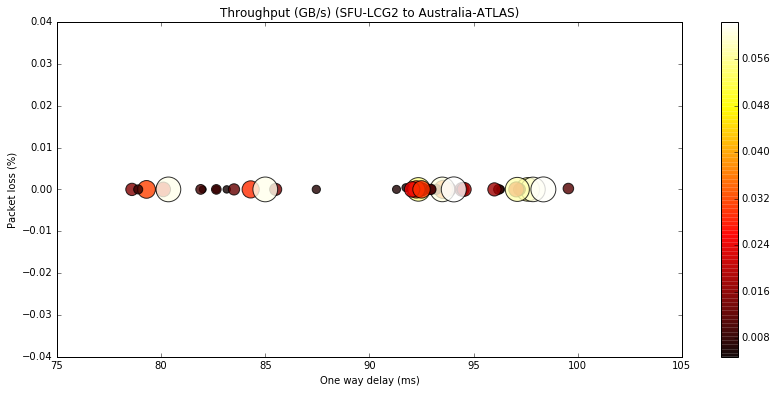

In [157]:
plt.figure(figsize=[14, 6])
plt.scatter(dm, pl, s=tp * 10000, c=tp, alpha=.8, cmap='hot')
plt.colorbar()
plt.xlabel('One way delay (ms)'), plt.ylabel('Packet loss (%)')
plt.title('Throughput (GB/s) (SFU-LCG2 to Australia-ATLAS)')
plt.show()

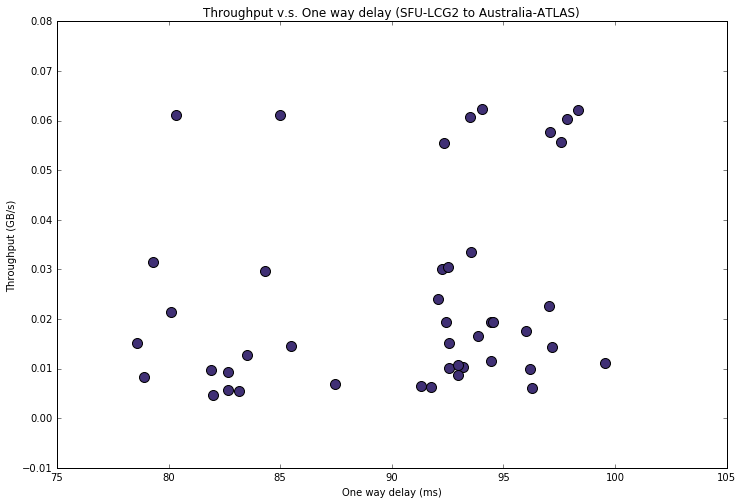

In [155]:
plt.figure(figsize=[12, 8])
plt.scatter(dm, tp, s=100, c='#403075')
plt.xlabel('One way delay (ms)'), plt.ylabel('Throughput (GB/s)')
plt.title('Throughput v.s. One way delay (SFU-LCG2 to Australia-ATLAS)')
plt.show()

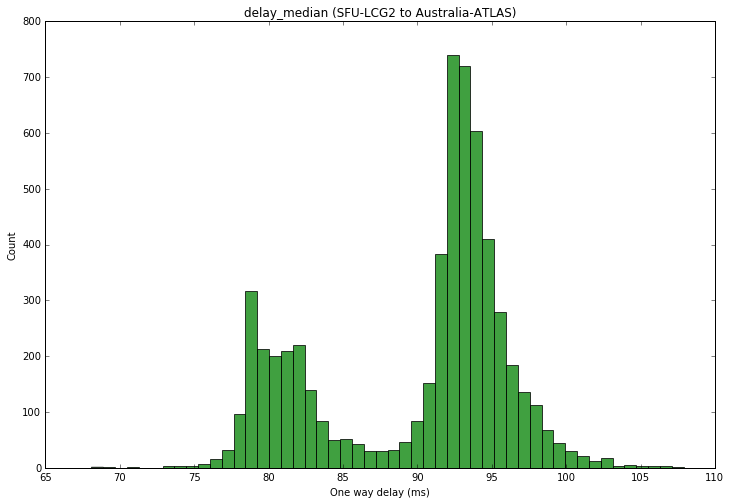

In [164]:
a = pd.read_pickle('raw_data_2.pkl')

d = a.delay_median
d = d[d.notnull()]

plt.figure(figsize=[12, 8])
plt.hist(d, 50, facecolor='green', alpha=0.75)
plt.xlabel('One way delay (ms)'), plt.ylabel('Count')
plt.title('delay_median (SFU-LCG2 to Australia-ATLAS)')

In [2]:
# Note that probably you should always require that srcProduction == True and destProduction == True